In [1]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline
# %matplotlib notebook
# cpu='0'
# os.environ['CUDA_VISIBLE_DEVICES']=cpu

# SETUP and load the datasets
import os
from bio_learn import *
import torch

# check whether CUDA is available
cuda_available = torch.cuda.is_available()
if cuda_available:
    print("CUDA is available")
else:
    print("CUDA is not available")
    
# Load pre-trained weights
np.random.seed(999)
force = False
file = './data/weights_0.pkl'
# if weights file is avaiable, load. Else, re-train and save it under ./data
if not force and os.path.isfile(file):
    weights = torch.load(file,map_location='cuda:0')
else:
    weights = get_unsupervised_weights(train_X, n_hidden=2000, n_epochs=200, batch_size=3584)          
    if not force: torch.save(weights, file)
    
# Load the dataset
(train_X, train_y), (test_X, test_y) = get_data('train'), get_data('test')
print('train_data, test_data:', train_X.shape, train_y.shape, test_X.shape, test_y.shape)

CUDA is available
train_data, test_data: torch.Size([60000, 784]) torch.Size([60000]) torch.Size([10000, 784]) torch.Size([10000])


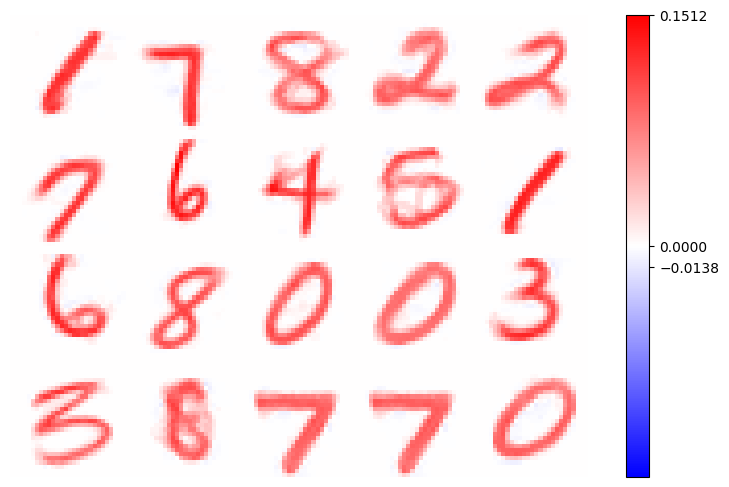

In [6]:
draw_weights(weights.cpu().numpy(), n_cols=5, n_rows=4)

In [2]:
# Simple CNN
print('\nSimpleConvNet Model')
SimpleConvNet_model =  SimpleConvNet().to("cuda")
run_test(train_X, train_y, test_X, test_y, SimpleConvNet_model, 10) # 0.97 


SimpleConvNet Model
hello
Final Validation Results - Epoch: 10  Avg accuracy: 0.9863 Avg loss: 0.04 Took: 33s


In [3]:
# use bio weights as the linear layer weights directly
print('\nSimpleBioClassifier Model')
# run_test(train_X, train_y, test_X, test_y, SimpleBioClassifier(weights, 10), 100, 1e-2) # 0.90 
run_test(train_X, train_y, test_X, test_y, SimpleBioClassifier(weights, 10).to("cuda"), 20) # 0.90 


SimpleBioClassifier Model
hello
Final Validation Results - Epoch: 20  Avg accuracy: 0.8710 Avg loss: 0.58 Took: 40s


In [4]:
# use bio weight as the 1 Conv weights + 1 linear layer output
print('\nBioConvClassifier Model')
run_test(train_X, train_y, test_X, test_y, BioConvClassifier(weights, 10).to("cuda"), 20) # 0.11


BioConvClassifier Model
hello
Final Validation Results - Epoch: 20  Avg accuracy: 0.1135 Avg loss: -996506.73 Took: 40s


In [5]:
# use bio weight(special technique to pass the weights) + 1 linear layer output - with Feedback alignment
print('\nBioClassifier w/ BioCell3 Model, with FA')
run_test(train_X, train_y, test_X, test_y, BioClassifier(BioCell3_withFA(weights)).to("cuda"), 10) # 0.10


BioClassifier w/ BioCell3 Model, with FA
hello


/home/yingwei/clps_project/unsupervised_bio_classifier/src/fa_linear.py:100: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight)
/home/yingwei/clps_project/unsupervised_bio_classifier/src/fa_linear.py:101: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight_fa)


Final Validation Results - Epoch: 10  Avg accuracy: 0.6425 Avg loss: 1.37 Took: 28s


In [6]:
# use bio weight(special technique to pass the weights) + 1 linear layer output - without Feedback alignment
print('\nBioClassifier w/ BioCell3 Model, without FA')
run_test(train_X, train_y, test_X, test_y, BioClassifier(BioCell3_withoutFA(weights)).to("cuda"), 10) # 0.10


BioClassifier w/ BioCell3 Model, without FA
hello
Final Validation Results - Epoch: 10  Avg accuracy: 0.7658 Avg loss: 1.16 Took: 34s


In [7]:
# use bio weights as Conv2d + 3 FC linear layers
print('\nBioFCN_FA_Classifier Model')
#run_test(train_X, train_y, test_X, test_y, BioConvClassifier2_model, 10, 1e-2) # 0.11 
run_test(train_X, train_y, test_X, test_y, BioFCN_FA_Classifier(weights).to("cuda"), 10) # 0.11 


BioFCN_FA_Classifier Model
hello


/home/yingwei/clps_project/unsupervised_bio_classifier/src/fa_linear.py:103: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  torch.nn.init.constant(self.bias, 1)


Final Validation Results - Epoch: 10  Avg accuracy: 0.9041 Avg loss: 3.67 Took: 57s


In [2]:
# use bio weights as Conv2d + 3 FC linear layers
print('\nBioFCN_without_FA_Classifier Model')
#run_test(train_X, train_y, test_X, test_y, BioConvClassifier2_model, 10, 1e-2) # 0.11 
run_test(train_X, train_y, test_X, test_y, BioFCN_without_FA_Classifier(weights).to("cuda"), 10) # 0.11 


BioFCN_without_FA_Classifier Model
hello
Final Validation Results - Epoch: 10  Avg accuracy: 0.9426 Avg loss: 0.19 Took: 33s


In [8]:
'''
200 epochs: 0.27 (200 epochs) 
switched WxH: 0.52
lr=1e-3: 0.94 -- SimpleConvNet got .97, modern SOTA is + .99
300 epochs: 0.97 
without switched WxH (takes 488s): 0.96
batch_size=1024 (takes 169s): 0.97 
batch_size=2048 (takes 168s): 0.97 
batch_size=3584 (takes 166s): 0.97 
nn.DataParallel (takes 167s): 0.97 -- undo
'''

print('\nBioClassifier w/ BioCell3 Model w/ BioLoss')
model = BioClassifier(BioCell3_withFA(weights)).to("cuda")
run_test(train_X, train_y, test_X, test_y, model, 200, batch_size=3584, lr=1e-4, loss=BioLoss(m=6))  


BioClassifier w/ BioCell3 Model w/ BioLoss
hello


/home/yingwei/clps_project/unsupervised_bio_classifier/src/fa_linear.py:100: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight)
/home/yingwei/clps_project/unsupervised_bio_classifier/src/fa_linear.py:101: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight_fa)


Final Validation Results - Epoch: 200  Avg accuracy: 0.9569 Avg loss: 1363075.17 Took: 168s


In [9]:
print('\nBioClassifier w/ BioCell3 Model w/ BioLoss w/o FA')
model = BioClassifier(BioCell3_withoutFA(weights)).to("cuda")
run_test(train_X, train_y, test_X, test_y, model, 200, batch_size=3584, lr=1e-4, loss=BioLoss(m=6))  


BioClassifier w/ BioCell3 Model w/ BioLoss w/o FA
hello
Final Validation Results - Epoch: 200  Avg accuracy: 0.9708 Avg loss: 1198869.71 Took: 153s


In [96]:
file = '../data/0010_model.pkl'
torch.save(model, file)